# Wav2Vec2-Base
## Overview
- We now import a pre-trained model from HuggingFace 🤗 and fine-tune it on a labelled dataset. Then, we test its performace on our usual benchmark dataset (LibriSpeech). In particular, the model ([Wav2Vec2](https://huggingface.co/docs/transformers/model_doc/wav2vec2)) was pre-trained in a complete unsupervised fashion using Masked Language Modeling (MLM) and constrastive learning to learn good audio features. As suggested in the paper, we will not fine-tune the feature extractor module because it already has good weights. During fine-tuning, we pick different splits both from [LIBRISPEECH](https://huggingface.co/datasets/librispeech_asr) (train-clean-100) and [FLEURS](https://huggingface.co/datasets/google/fleurs) labelled speech dataset. We then assess the performance of the fine-tuned model on the Librispeech benchmark (dev-clean, dev-other, test-clean, test-other). We believe that given a well-enough pre-trained model, it is sufficient to fine-tune it on few examples (<1 hour of labelled speech) to obtain sufficiently good performance on unseen audio data.

## Libraries
- if using a Colab session, create `utils` folder and add `preprocessing.py` file.
- create `audioset` folder.

In [ ]:
%%capture
! pip install accelerate
! pip install datasets
! pip install jiwer

In [7]:
# Main libraries
import numpy as np
import torch
import pandas as pd
import accelerate

# Datasets
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from datasets import Dataset as HFDataset
from utils.preprocessing import Preprocessing

# Hugging Face
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC
from transformers import TrainingArguments
from transformers import Trainer

# Others
import re
import inflect
import json
import IPython.display as ipd
import matplotlib.pyplot as plt
import textwrap
from tqdm import tqdm
#import wandb

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Datasets
Regarding the training phase, we train on different splits of the LIBRISPEECH dataset and FLEURS dataset.



In [ ]:
prep = Preprocessing()

In [19]:
def get_data_list(dataset, max_samples):
    if max_samples > len(dataset):
        max_samples = len(dataset)
        print(f"Warning: max_samples clamped to len(dataset) ({len(dataset)})")

    data_list = [{  "num_samples":      dataset[i][0].shape[-1],
                    "audio":            dataset[i][0].squeeze().numpy(),
                    "transcription":    dataset[i][2] }
                    for i in tqdm(range(max_samples))]
    return data_list

**FLEURS**🌼
- FLEURS Small (520 samples, ~1.4 hours)
- FLEURS Mid (1301 samples, ~3.5 hours)
- FLEURS Large (2081 samples, ~5.7 hours)

In [ ]:
fleurs = load_dataset("google/fleurs", "en_us", split="train", trust_remote_code=True)

useless_columns = ["id", "path", "raw_transcription", "gender", "lang_id", "language", "lang_group_id"]
fleurs = fleurs.remove_columns(useless_columns)

def format_audio(x):
    x["audio"] = x["audio"]["array"]
    return x

fleurs = fleurs.map(format_audio)

In [11]:
def get_fleurs_split(dataset, split='small'):
    if split not in {'small', 'mid', 'large'}:
        return "Wrong argument"
    train_size = 0.0
    if split == 'small':
        train_size = 0.2
    elif split == 'mid':
        train_size = 0.5
    else:
        train_size = 0.8
    return dataset.train_test_split(train_size=train_size)["train"]

fleurs = get_fleurs_split(fleurs, split='small')

**LIBRISPEECH**📕
- LIBRI Small (2000 clean samples)
- LIBRI Mid (4000 clean samples)
- LIBRI Large (6000 clean samples)

In [ ]:
train_clean = prep.download(split='train-clean-100', download=True) # 28539 samples

def get_libri_split(dataset, split='small'):
    if split not in {'small', 'mid', 'large'}:
        return "Wrong argument"
    max_samples = 0
    if split == 'small':
        max_samples = 2_000
    elif split == 'mid':
        max_samples = 4_000
    else:
        max_samples = 6_000
    return HFDataset.from_list(get_data_list(train_clean, max_samples=max_samples))

c:\Users\marco\.conda\envs\exp\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
libri = get_libri_split(train_clean, split='small')

100%|██████████| 2000/2000 [00:32<00:00, 61.12it/s]


- Pick the train set HERE

In [12]:
train_set = fleurs
#train_set = libri

In [13]:
pd.DataFrame(train_set[:3])

,num_samples,audio,transcription
0,243840,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",final results from namibian presidential and p...
1,97920,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lions cheetahs and leopards are sometimes shy ...
2,89280,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",smaller tournaments and matches can also be se...


TEST sets. Pick among
- `dev-clean`: 2073 samples
- `dev-other`: 2864 samples
- `test-clean`: 2620 samples
- `test-other`: 2939 samples

In [20]:
test_set_list = ['dev-clean', 'dev-other', 'test-clean', 'test-other']
test_set_name = test_set_list[0]# change split number here

test_set = prep.download(split=test_set_name, download=True)

# Set here the test set
test_set = HFDataset.from_list(get_data_list(test_set, len(test_set)))

100%|██████████| 2703/2703 [00:25<00:00, 104.15it/s]


In [21]:
pd.DataFrame(test_set[:3])

,num_samples,audio,transcription
0,93680,"[0.00238037109375, 0.0020751953125, 0.00198364...",MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CL...
1,77040,"[-0.000152587890625, -9.1552734375e-05, -0.000...",NOR IS MISTER QUILTER'S MANNER LESS INTERESTIN...
2,199760,"[-0.00067138671875, 6.103515625e-05, 0.0005187...",HE TELLS US THAT AT THIS FESTIVE SEASON OF THE...


## Text normalization
- convert symbols (e.g. %, $, €) to their word transcription
- convert to lowercase
- convert numbers to words
- create a vocabulary (letters + apostrophe + space)

In [22]:
text_column = "transcription"
p = inflect.engine()

def numbers_to_words(text):
    words = []
    for word in text.split():
        if word.isdigit():
            words.append(p.number_to_words(word))
        else:
            words.append(word)
    return " ".join(words)

def normalize_text(text):
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar')
    text = text.replace('€', ' euro')

    text = re.sub(r"[^a-zA-Z0-9\s']", '', text).lower()

    text = numbers_to_words(text)
    text = re.sub(r"[^a-zA-Z\s']", '', text).lower()

    return text

def create_vocabulary(dataset):
    all_text = ""
    for example in dataset:
        normalized_text = normalize_text(example[text_column])
        all_text += normalized_text
    unique_chars = sorted(set(all_text))
    return unique_chars

- create vocabulary, with additional `[PAD]` and `[UNK]` tokens
- save vocabulary to json

In [23]:
vocab_list = create_vocabulary(train_set)
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

vocab_dict["[SPACE]"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

vocab_name = "vocab.json"
with open(vocab_name, 'w') as file:
    json.dump(vocab_dict, file, indent=4)
    print('JSON dumped!')

JSON dumped!


- put normalized text in Dataset object

In [24]:
def normalize_text(example):
    normalized_text = example[text_column]

    normalized_text = normalized_text.replace('%', ' percent')
    normalized_text = normalized_text.replace('$', ' dollar')
    normalized_text = normalized_text.replace('€', ' euro')

    normalized_text = re.sub(r"[^a-zA-Z0-9\s']", '', normalized_text).lower()

    normalized_text = numbers_to_words(normalized_text)
    normalized_text = re.sub(r"[^a-zA-Z\s']", '', normalized_text).lower()

    example["text"] = normalized_text
    return example

In [25]:
train_set = train_set.map(normalize_text)

Map:   0%|          | 0/520 [00:00<?, ? examples/s]

In [26]:
test_set = test_set.map(normalize_text)

Map:   0%|          | 0/2703 [00:00<?, ? examples/s]

Now, the Dataset object contains the following columns
- `num_samples`: length of the audio speech
- `audio`: list of floats describing the audiowave
- `transcription`: unnormalized text transcription
- `text`: normalized transcription

In [27]:
pd.DataFrame(train_set[:3])

,num_samples,audio,transcription,text
0,243840,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",final results from namibian presidential and p...,final results from namibian presidential and p...
1,97920,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lions cheetahs and leopards are sometimes shy ...,lions cheetahs and leopards are sometimes shy ...
2,89280,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",smaller tournaments and matches can also be se...,smaller tournaments and matches can also be se...


In [29]:
pd.DataFrame(test_set[:3])

,num_samples,audio,transcription,text
0,93680,"[0.00238037109375, 0.0020751953125, 0.00198364...",MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CL...,mister quilter is the apostle of the middle cl...
1,77040,"[-0.000152587890625, -9.1552734375e-05, -0.000...",NOR IS MISTER QUILTER'S MANNER LESS INTERESTIN...,nor is mister quilter's manner less interestin...
2,199760,"[-0.00067138671875, 6.103515625e-05, 0.0005187...",HE TELLS US THAT AT THIS FESTIVE SEASON OF THE...,he tells us that at this festive season of the...


## Tokenization
- we tokenize audio speech and text transcription
- `input_values`: tokenized speech
- `input_length`: length of speech
- `labels`: tokenized transcription

In [30]:
tokenizer = Wav2Vec2CTCTokenizer(f"./{vocab_name}",
                                 unk_token="[UNK]",
                                 pad_token="[PAD]",
                                 word_delimiter_token="[space]")

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1,
                                             sampling_rate=16_000,
                                             padding_value=0.0,
                                             do_normalize=True,
                                             return_attention_mask=False)

processor = Wav2Vec2Processor(feature_extractor=feature_extractor,
                              tokenizer=tokenizer)


Inspection time! 👀
- show random sample and PLAY it!
- choose audioset from the following available sets

In [32]:
dummy_audioset = ('train_set', train_set)
#dummy_audioset = ('test_set', test_set)

id = np.random.randint(low=0, high=(len(dummy_audioset[-1])))

print(f">>> {dummy_audioset[0].upper()} audioset <<<\n")
print(textwrap.fill(dummy_audioset[-1][id]['text'], 40))

display(ipd.Audio(data=np.asarray(dummy_audioset[-1][id]["audio"]), rate=16_000))

>>> TRAIN_SET audioset <<<

hesperonychus elizabethae is a species
of the family dromaeosauridae and is a
cousin of velociraptor


- preparing the dataset
- we need to have `input_values`, `input_length`, and `labels` to be fed to the model

In [33]:
def prepare_dataset(batch):
    # call feature extractor
    batch["input_values"] = processor(batch["audio"], sampling_rate=16_000).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    # call tokenizer
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [34]:
train_set = train_set.map(prepare_dataset)#, num_proc=4)

Map:   0%|          | 0/520 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [40]:
pd.DataFrame(train_set[:3])

,num_samples,audio,transcription,text,input_values,input_length,labels
0,243840,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",final results from namibian presidential and p...,final results from namibian presidential and p...,"[0.0007229371112771332, 0.0007229371112771332,...",243840,"[7, 10, 15, 2, 13, 28, 20, 17, 2, 4, 6, 28, 19..."
1,97920,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lions cheetahs and leopards are sometimes shy ...,lions cheetahs and leopards are sometimes shy ...,"[6.626300455536693e-05, 6.626300455536693e-05,...",97920,"[13, 10, 16, 15, 20, 28, 20, 17, 2, 4, 6, 28, ..."
2,89280,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",smaller tournaments and matches can also be se...,smaller tournaments and matches can also be se...,"[0.001603487296961248, 0.001603487296961248, 0...",89280,"[20, 14, 2, 13, 13, 6, 19, 28, 20, 17, 2, 4, 6..."


In [36]:
test_set = test_set.map(prepare_dataset)

Map:   0%|          | 0/2703 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [41]:
pd.DataFrame(test_set[:3])

,num_samples,audio,transcription,text,input_values,input_length,labels
0,93680,"[0.00238037109375, 0.0020751953125, 0.00198364...",MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CL...,mister quilter is the apostle of the middle cl...,"[0.038578689098358154, 0.03365164250135422, 0....",93680,"[14, 10, 20, 21, 6, 19, 28, 20, 17, 2, 4, 6, 2..."
1,77040,"[-0.000152587890625, -9.1552734375e-05, -0.000...",NOR IS MISTER QUILTER'S MANNER LESS INTERESTIN...,nor is mister quilter's manner less interestin...,"[-0.0015195695450529456, -0.000766539014875888...",77040,"[15, 16, 19, 28, 20, 17, 2, 4, 6, 28, 10, 20, ..."
2,199760,"[-0.00067138671875, 6.103515625e-05, 0.0005187...",HE TELLS US THAT AT THIS FESTIVE SEASON OF THE...,he tells us that at this festive season of the...,"[-0.008716928772628307, 0.0009564861538819969,...",199760,"[9, 6, 28, 20, 17, 2, 4, 6, 28, 21, 6, 13, 13,..."


- We plot the histograms of the speech duration and text length for both train and test sets

In [48]:
def plot_duration(dataset, title, sampling_rate=16_000, verbose=True):
    duration_length = [input_length / sampling_rate for input_length in dataset['input_length']]
    mean_duration = np.mean(duration_length)
    min_duration = np.min(duration_length)
    max_duration = np.max(duration_length)

    plt.figure(figsize=(6, 3))
    plt.hist(duration_length, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'{title.upper()} speech length', fontsize=16)
    plt.xlabel('Duration (seconds)', fontsize=14)
    plt.ylabel('# samples', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    if verbose:
        print(">>> Durations")
        print(f"min:\t{min_duration:.2f} seconds")
        print(f"mean:\t{mean_duration:.2f} seconds")
        print(f"max:\t{max_duration:.2f} seconds")

def plot_text_length(dataset, title, verbose=True):
    text_length = [len(text) for text in dataset['text']]
    mean_text = np.mean(text_length)
    min_text = np.min(text_length)
    max_text = np.max(text_length)

    plt.figure(figsize=(6, 3))
    plt.hist(text_length, bins=30, color='orange', edgecolor='black')
    plt.title(f'{title.upper()} text length', fontsize=16)
    plt.xlabel('Length (chars)', fontsize=14)
    plt.ylabel('# samples', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    if verbose:
        print(">>> Lengths")
        print(f"min:\t{min_text:.2f} chars")
        print(f"mean:\t{mean_text:.2f} chars")
        print(f"max:\t{max_text:.2f} chars")

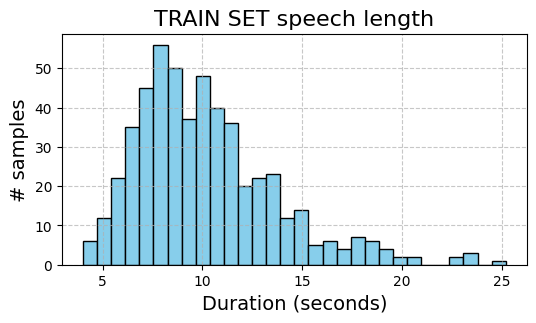

>>> Durations
min:	4.02 seconds
mean:	10.20 seconds
max:	25.20 seconds


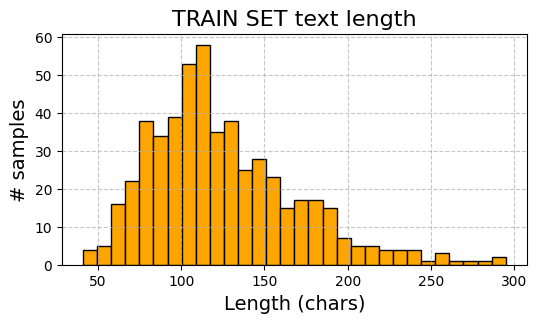

>>> Lengths
min:	41.00 chars
mean:	125.37 chars
max:	295.00 chars


In [49]:
plot_duration(train_set, title='train set')
plot_text_length(train_set, title='train set')

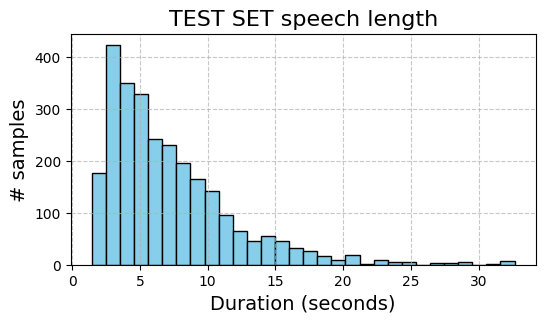

>>> Durations
min:	1.45 seconds
mean:	7.18 seconds
max:	32.65 seconds


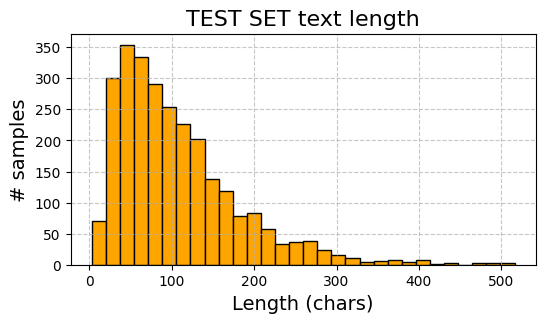

>>> Lengths
min:	3.00 chars
mean:	106.72 chars
max:	516.00 chars


In [50]:
plot_duration(test_set, title='test set')
plot_text_length(test_set, title='test set')

## Training 🥋
To fine-tune Wav2Vec2 we need:
- a data collator: we pad input sequences dinamically, i.e. training samples are padded to the longest sequence in their batch
- an evaluation metric: we define a function to compute the Word Error Rate (WER), that will be computed on the dev set after a certain amount of steps
- a checkpoint: we joust load model card from 🤗

The DataCollator Class was copied from [this repo](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81). Since audio and text belong to different modalities, we need to using different padding strategies.

In [51]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [52]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Metrics - Word Error Rate
- we use a greedy decoding approach, i.e. taking the argmax along the logit vector (most probable character)
- we transform the encoded labels back tot the original string replacing `-100` with `pad_token_id`

In [56]:
wer_metric = load_metric("wer", trust_remote_code=True)

In [57]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

We are now ready to load the checkpoint from the Hugging Face Hub

In [58]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
model.freeze_feature_encoder()

In [65]:
training_args = TrainingArguments(
  output_dir="wav2vec2-base",
  group_by_length=True,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=True,
  gradient_checkpointing=True,
  save_steps=300,
  eval_steps=300,
  logging_steps=300,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=600,
  save_total_limit=2,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_set,
    eval_dataset=test_set,
    tokenizer=processor.feature_extractor,
)
trainer.train()

## Evalutation 📈

In [ ]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)

  return batch

results = test_set.map(map_to_result, remove_columns=test_set.column_names)

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

In [ ]:
pd.DataFrame(results[:10])